In [1]:
import gc
import os
import numpy as np 
import pandas as pd 
import utils.paths as plh
import utils.read_utils as hlpread
from sklearn.pipeline import Pipeline
from src.models.feature_eng.TE_KFold import KFoldTargetEncoder
from src.models.feature_eng.FreqEncoding import FrequencyEncoding
from src.models.feature_eng.Combine_feature import CombineFeatures
from src.models.feature_eng.KFoldFreqEncoding import KFoldFrequencyEncoding
from src.models.feature_eng.CountVectorizerEncoding import CountVectorizerEncoding
from src.models.feature_eng.TFIDFVectorizerEncoding import TFIDFVectorizerEncoding

In [2]:
PROJECT_ROOT = plh.get_project_root()

train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
train = hlpread.read_from_parquet(train_data)

print(train.shape)

print(train.columns)
#col_use = [x for x in train.columns if not x in ['ROLE_TITLE', 'MGR_ID']]
#train = train[col_use]
#targetcol = 'ACTION'

#te_col = list(train.columns)
#te_col.remove(targetcol)

(30391, 10)
Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder

feature_engg = Pipeline( steps = [
                                    ('combine_feature', CombineFeatures()),
                                    #('label_encoder', LabelEncoder()),
                                ]
                         ,verbose =  True
                        )  

X = feature_engg.fit_transform(train) 

X.columns        

In [ ]:
#Order of the pipeline matter as this impact the output
feature_engg = Pipeline( steps = [
                                ('combine_feature', CombineFeatures()),

                                #('frequency_encoding', FrequencyEncoding(min_group_size = 2)),

                                #('tfidf_vectorizer_encoding', TFIDFVectorizerEncoding()),

                                ('count_vectorizer_encoding', CountVectorizerEncoding()),

                                ('KFoldTE', KFoldTargetEncoder()),

                                ]
                              ,verbose =  True
                        )                        


X = feature_engg.fit_transform(train) 

X.shape

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

chi2_feature = SelectKBest(chi2, k = 29)
best_feature = chi2_feature.fit_transform(X_2, X.ACTION)


In [ ]:
chi2_feature.scores_

In [ ]:
chi2_feature.scores_.argsort()

In [ ]:
chi2_feature.feature_names_in_

In [ ]:
chi2_feature.feature_names_in_[chi2_feature.scores_.argsort()]

In [ ]:
best_feature

## Eval model ##

In [5]:
from src.models.predict_model import employee_access_resource

model_obj = employee_access_resource(os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.model_path')),
                                     os.path.join(PROJECT_ROOT, hlpread.read_yaml_key('trained_model.feature_eng')))


In [6]:
Y_predictions_by_class = model_obj.predict(train).astype(float) #Return 2d numpy array which is the probaility for each class label
Y = train['ACTION'].astype(float)

In [7]:
Y_predictions_by_class

array([[0.07586724, 0.92413276],
       [0.07586724, 0.92413276],
       [0.07586724, 0.92413276],
       ...,
       [0.10900408, 0.89099592],
       [0.08295166, 0.91704834],
       [0.14121997, 0.85878003]])

Text(0, 0.5, 'True positive rate')

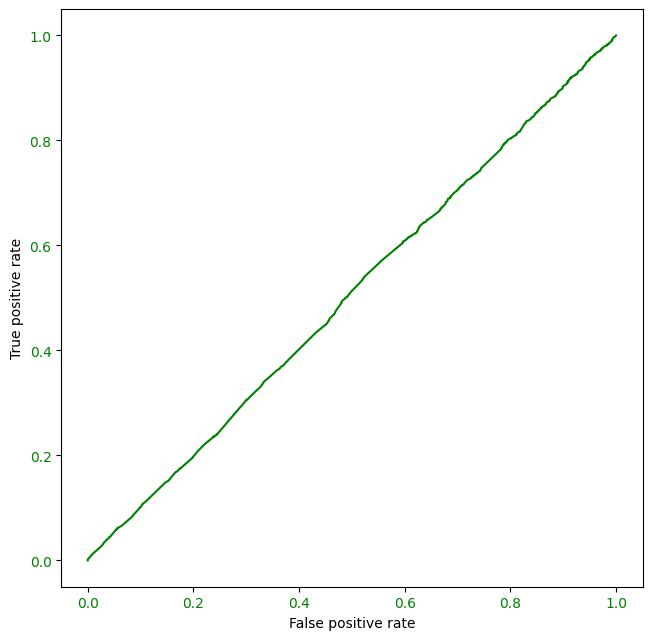

In [8]:

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y, Y_predictions_by_class[:,1])
roc_auc_curve_df = pd.DataFrame()    
roc_auc_curve_df['false_positive_rates'] = fpr
roc_auc_curve_df['true_positive_rates'] = tpr
roc_auc_curve_df['thresholds'] = thresholds

fig, ax = plt.subplots(figsize = (7.5, 7.5))
ax.plot(roc_auc_curve_df['false_positive_rates'], roc_auc_curve_df['true_positive_rates'],  color = 'green', label = 'ROC Curve') #, marker = 'o'

ax.tick_params(axis = 'both', labelcolor = 'green')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
#label_str = str.format('ROC-AUC: {0}',  round(auc_score, 3))
#ax.text(0.5, 0, label_str, fontsize = 6)

In [ ]:
Y_pred = Y_predictions_by_class.argmax(-1)  
conf_matrix = confusion_matrix(Y, Y_pred)

print(conf_matrix)

In [ ]:
auc_score